In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

from time import time
import psutil

from tqdm.notebook import tqdm
from collections import defaultdict
from ipywidgets import interact
import multiprocessing as mp

import tenseal as ts

%matplotlib inline

In [2]:
df = pd.read_csv("immo_data.csv")

columns_to_drop = ['serviceCharge', 'telekomTvOffer', 'noParkSpaces', 'pricetrend','regio3', 'heatingType', 'telekomUploadSpeed', 'telekomHybridUploadSpeed', 'lastRefurbish', 'newlyConst', 'picturecount', 'firingTypes', 'hasKitchen', 'geo_bln','cellar', 'yearConstructedRange', 'baseRent', 'houseNumber', 'geo_krs', 'interiorQual', 'petsAllowed', 'street', 'streetPlain', 'baseRentRange', 'geo_plz', 'thermalChar', 'floor', 'numberOfFloors', 'noRoomsRange', 'garden', 'livingSpaceRange', 'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass', 'electricityBasePrice', 'electricityKwhPrice', 'date' ]
df = df.drop(columns=columns_to_drop, axis=1)
df['regio1'] = df.regio1.astype('category')
df['regio2'] = df.regio1.astype('category')
df['balcony'] = df['balcony'].astype(int)
df['lift'] = df['lift'].astype(int)
df['condition'] = df.condition.astype('category')
df['typeOfFlat'] = df.typeOfFlat.astype('category')
df = df.dropna()
df = df[(df['totalRent'] != 0) & (df['livingSpace'] != 0) & (df['yearConstructed'] > 1940) & (df['yearConstructed'] < 2021)]
numerical_cols = ['totalRent', 'yearConstructed', 'livingSpace', 'noRooms']
# Remove outliers
q3 = df.loc[:, numerical_cols].describe().loc['75%']
iqr = q3 - df.loc[:, numerical_cols].describe().loc['25%']
upper_boundary = q3 + 1.5*iqr
upper_boundary

df = df[(df.totalRent <= upper_boundary.totalRent) &
        (df.yearConstructed <= upper_boundary.yearConstructed) &
        (df.livingSpace <= upper_boundary.livingSpace) &
         (df.noRooms <= upper_boundary.noRooms) ]

df = pd.concat([df, pd.get_dummies(df.regio1)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.regio2)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.condition)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.typeOfFlat)], axis='columns')
df.drop('regio1', axis='columns', inplace=True)
df.drop('regio2', axis='columns', inplace=True)
df.drop('condition', axis='columns', inplace=True)
df.drop('typeOfFlat', axis='columns', inplace=True)
df.drop(['scoutId'], axis='columns', inplace=True)

train_rents, test_rents = train_test_split(df, test_size=0.4, random_state=42, shuffle=True)
scaler = StandardScaler()
train_rents = pd.DataFrame(scaler.fit_transform(train_rents), columns=train_rents.columns, index=train_rents.index)
test_rents = pd.DataFrame(scaler.transform(test_rents), columns=test_rents.columns, index=test_rents.index)
X_train_rents = train_rents.drop(columns=["totalRent"]).values
X_test_rents = test_rents.drop(columns=["totalRent"]).values
y_train_rents = train_rents.totalRent.values
y_test_rents = test_rents.totalRent.values



In [3]:
# [print(x) for x in X_train_rents]
X_train_rents.shape

(52385, 57)

In [4]:
def context():
# parameters
    poly_mod_degree = 8192
    coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
    # create TenSEALContext
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    context.global_scale = 2 ** 21
    context.generate_galois_keys()
    return context

context = context()

In [5]:
# t_start = time()
# enc_x_train = [ts.ckks_vector(context, x) for x in X_train_rents[:10000, :]]
# enc_y_train = [ts.ckks_vector(context, [x]) for x in y_train_rents[:10000]]
# t_end = time()
# print(f"Encryption of the train-set took {int(t_end - t_start)} seconds")
def encrypt_trainset(X, y):    

    enc_x_train = [ts.ckks_vector(context, x) for x in X]
    enc_y_train = [ts.ckks_vector(context, [x]) for x in y]

    return enc_x_train, enc_y_train




In [6]:
def encrypt_trainset_tensor(X, y):    

    enc_x_train = ts.ckks_tensor(context, X)
    enc_y_train = ts.ckks_tensor(context, y)

    return enc_x_train, enc_y_train

In [7]:
# cpu_percent = psutil.cpu_percent()
# mem_usage = psutil.Process().memory_info().rss
# t_start = time()


# enc_x_train, enc_y_train = encrypt_trainset_tensor(X_train_rents[:75], y_train_rents[:75])

# Measure CPU and memory usage again
# cpu_percent_end = psutil.cpu_percent()
# mem_usage_end = psutil.Process().memory_info().rss

# # Calculate the differences
# cpu_diff = cpu_percent_end - cpu_percent
# mem_diff = mem_usage_end - mem_usage
# t_end = time()
# print(f"Encryption of the train-set took {int(t_end - t_start)} seconds")

# print(f"CPU usage difference: {cpu_diff}%")
# print(f"Memory usage difference: {mem_diff} bytes")

In [8]:
# encrypted Mean squared error
def enc_cost(y_enc, y_encpred, N):
    cost = y_enc.sub(y_encpred).square().sum() * (2 * N)
    return cost

In [9]:
def cost(y, y_pred):
    cost = np.sum(np.square(y - y_pred))/ (2 * len(y))
    return cost

In [10]:
def enc_predict(enc_X, bias, thetas):
    return ts.plain_tensor(bias) + enc_X.dot(thetas)

In [11]:
def predict(X, bias, thetas):

    y_pred = bias + np.dot(X, thetas)
    return y_pred

In [12]:
def enc_gradient(X, y, bias, thetas, N):
    diff = enc_predict(X, bias, thetas) - y
    grad_bias = diff.sum() * N
    grad_thetas = diff.dot(X) * N
    return grad_bias, grad_thetas

In [13]:
def gradient(X, y, bias, thetas):
    diff = predict(X, bias, thetas) - y
    n = len(X)
    grad_bias = np.sum(diff) / n
    grad_thetas = np.dot(diff, X) / n
    
    return grad_bias, grad_thetas

In [14]:
def enc_mean(enc_y, N):
    return enc_y.sum() * N

In [15]:
def enc_r2(y, y_pred, N):
    return 1 - ((enc_cost(y, y_pred, N)) * ts.plain_tensor(1 / np.array(enc_cost(y, enc_mean(y, N), N).decrypt().tolist())))


In [16]:
def enc_fit_minibatch(X_train, y_train, alpha, num_epochs, reciprocal_N, batch_size, display_every=50):
    number_features = X_train.shape[1]
    bias = 0.0
    thetas = np.random.randn(*(1, number_features )).reshape(-1)
    num_samples = len(X_train)
    indices_train = np.arange(len(X_train))
    
    steps = int(num_samples/batch_size)

    hist = defaultdict(list)
    for epoch in tqdm(range(1, num_epochs+1)):
        np.random.shuffle(indices_train)
        
        X_train_epoch = X_train[indices_train]
        y_train_epoch = y_train[indices_train]

        for step in range(steps):
            start = step * batch_size
            end = step * batch_size + batch_size
            
            X_train_mini = X_train_epoch[start:end]
            y_train_mini = y_train_epoch[start:end]
            enc_x_train, enc_y_train = encrypt_trainset_tensor(X_train_mini, y_train_mini)

            grad_bias, grad_thetas = enc_gradient(enc_x_train, enc_y_train, bias, thetas, reciprocal_N)
            bias = bias - alpha * np.array(grad_bias.decrypt().tolist())
            thetas = thetas - alpha * np.array(grad_thetas.decrypt().tolist())

        # print("type x_train_sample: {}".format(type(enc_x_train[sample])))
        y_pred_train = enc_predict(enc_x_train, bias, thetas)
        # print("type y_train_sample: {}, type y_pred_train: {}".format(type(enc_y_train[sample]), type(y_pred_train)))
        train_cost = np.array(enc_cost(enc_y_train, y_pred_train, reciprocal_N).decrypt().tolist())
        train_r2 = np.array(enc_r2(enc_y_train, y_pred_train, reciprocal_N).decrypt().tolist())
        
        hist["train_cost"].append(train_cost)
        hist["train_r2"].append(train_r2)
        
        if epoch % display_every == 0:
            print("Epoch {0} - cost: {1:.2} - r2: {2:.4}"
                .format(epoch, train_cost, train_r2))
        
    return bias, thetas, hist

In [17]:
def enc_fit(X_train, y_train, alpha, num_epochs, reciprocal_N, display_every=50):
    number_features = X_train.shape[1]
    bias = 0.0
    thetas = np.random.randn(*(1, number_features )).reshape(-1)
    
    hist = defaultdict(list)
    for epoch in tqdm(range(1, num_epochs+1)):
        
        grad_bias, grad_thetas = enc_gradient(X_train, y_train, bias, thetas, reciprocal_N)
        bias = bias - alpha * np.array(grad_bias.decrypt().tolist())
        thetas = thetas - alpha * np.array(grad_thetas.decrypt().tolist())

        y_pred_train = enc_predict(X_train, bias, thetas)
        train_cost = np.array(enc_cost(y_train, y_pred_train, reciprocal_N).decrypt().tolist())
        train_r2 = np.array(enc_r2(y_train, y_pred_train, reciprocal_N).decrypt().tolist())
        
        hist["train_cost"].append(train_cost)
        hist["train_r2"].append(train_r2)
        
        if epoch % display_every == 0:
            print("Epoch {0} - cost: {1:.2} - r2: {2:.4}"
                  .format(epoch, train_cost, train_r2))
        
    return bias, thetas, hist

In [18]:
len_taken = 1000
batch_size = 75
reciprocal_N = 1 / batch_size

alpha = 0.01
num_epochs = 5
enc_bias, enc_thetas, hist_rent_enc = enc_fit_minibatch(X_train_rents[:len_taken], y_train_rents[:len_taken], alpha, num_epochs, reciprocal_N, batch_size)

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
# reciprocal_N = 1 / 75
# alpha = 0.01
# num_epochs = 100
# enc_bias, enc_thetas, hist_rent_enc = enc_fit(enc_x_train, enc_y_train, alpha, num_epochs, reciprocal_N)

In [20]:
def fit(X_train, y_train, alpha, num_epochs, batch_size, display_every=50):
    bias = 0.0
    thetas = np.random.randn(*(1, X_train.shape[1])).reshape(-1)
    hist = defaultdict(list)
    
    indices_train = np.arange(len(X_train))   
    
    num_samples = len(X_train)
    steps = int(num_samples/batch_size)
    
    for epoch in tqdm(range(1, num_epochs + 1)):
        # randomize inputs
        np.random.shuffle(indices_train)
        
        X_train_epoch = X_train[indices_train]
        y_train_epoch = y_train[indices_train]
        
        for step in range(steps):
            start = step * batch_size
            end = step * batch_size + batch_size
            
            X_train_mini = X_train_epoch[start:end]
            y_train_mini = y_train_epoch[start:end]
        
            grad_bias, grad_thetas = gradient(X_train_mini, y_train_mini, bias, thetas)
            bias = bias - alpha * grad_bias
            thetas = thetas - alpha * grad_thetas

        y_pred_train = predict(X_train, bias, thetas)
        
        train_cost = cost(y_train, y_pred_train)
        train_r2 = r2_score(y_train, y_pred_train)

        hist["train_cost"].append(train_cost)
        hist["train_r2"].append(train_r2)
        
        if epoch % display_every == 0 or epoch == num_epochs:
            print("Epoch {0} - train_cost: {1:.2} - train_r2: {2:.4}".format(epoch, train_cost, train_r2))
        
    return bias, thetas, hist

In [21]:
def plot_validation_curve(data, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title("Validation Curve")
        ax.set_ylabel("Cost")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel("Epochs")
    ax.plot(data)


def plot_validation_curves(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    plot_validation_curve(hist["train_cost"], ax[0], ylim)

    ax[1].set_title("Train R2")
    ax[1].set_ylabel("R2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist["train_r2"], ax[1])

    plt.tight_layout()

In [22]:
bias, thetas, hist_rent = fit(X_train_rents[:len_taken], y_train_rents[:len_taken], alpha, num_epochs, batch_size)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 - train_cost: 5.2 - train_r2: -9.981


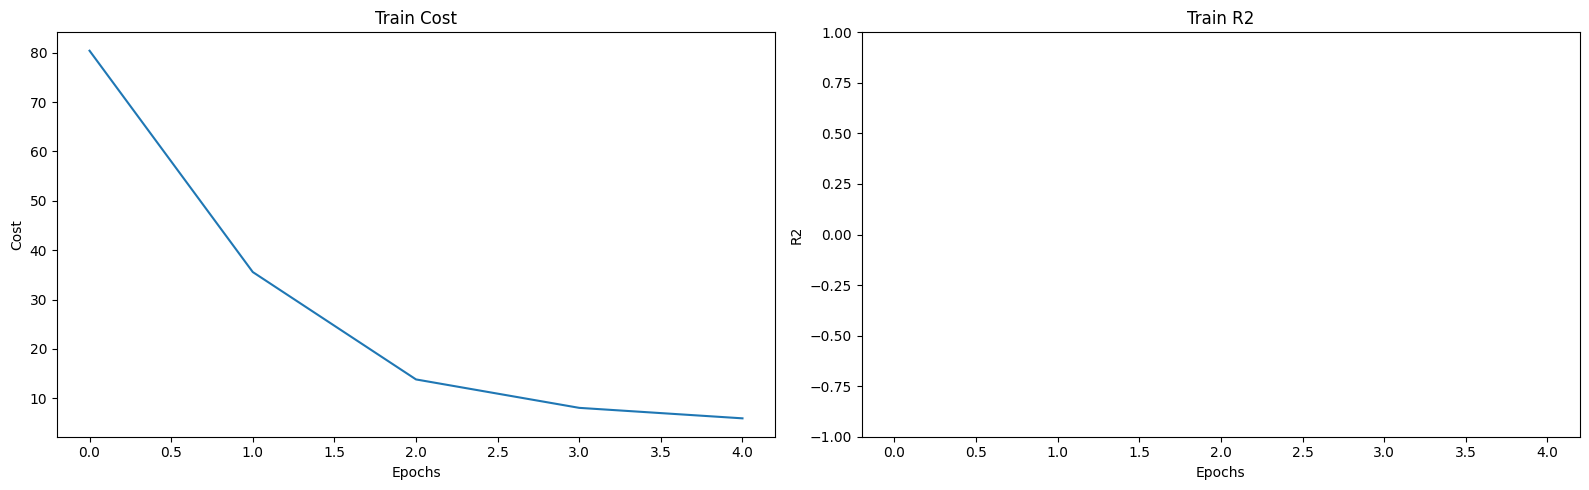

In [28]:
plot_validation_curves(hist_rent_enc)

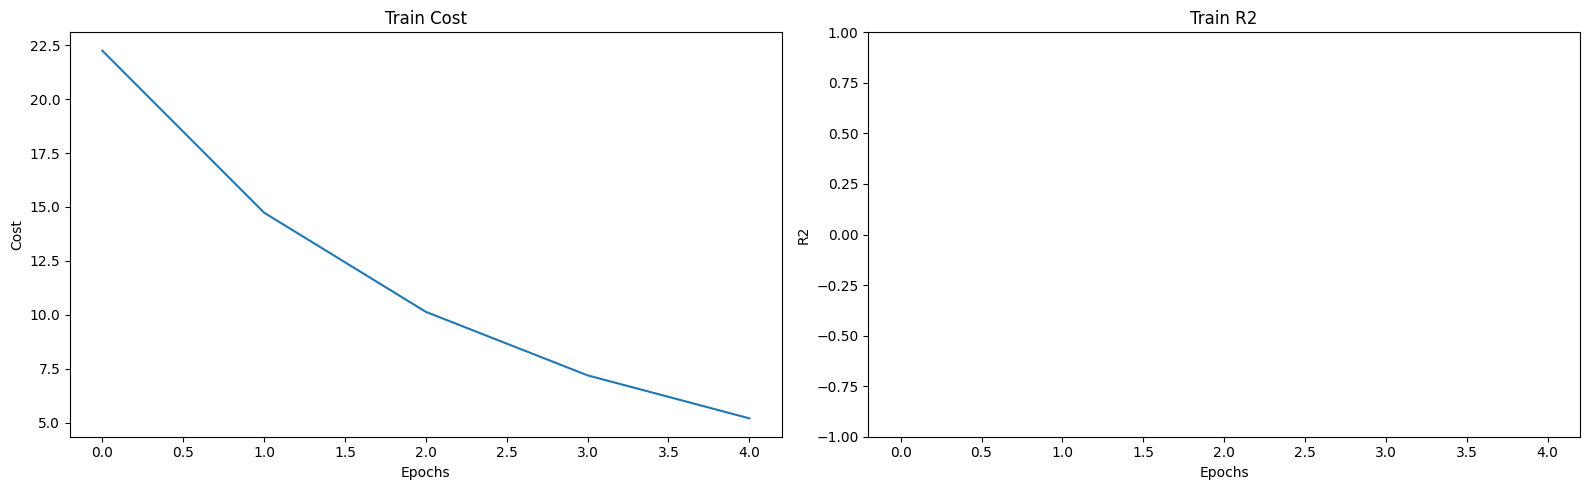

In [24]:
plot_validation_curves(hist_rent)

In [29]:
print(hist_rent['train_r2'])
print(hist_rent_enc['train_r2'])

[-46.02273942564584, -30.14503146518356, -20.42159208058732, -14.195573352455549, -9.981407832343328]
[array(-43.77293332), array(-18.27401865), array(-5.29683235), array(-3.20162719), array(-2.81123042)]


In [26]:
y_pred_rents_enc = predict(X_test_rents, enc_bias, enc_thetas)
r2 = r2_score(y_test_rents, y_pred_rents_enc)
print("R2:", r2)

R2: -0.8772842114237864


In [27]:
y_pred_rents = predict(X_test_rents, bias, thetas)
r2 = r2_score(y_test_rents, y_pred_rents)
print("R2:", r2)

R2: -9.172573261716115
